In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import scipy as sp
from scipy import interpolate, signal
import random
import pandas as pd
import warnings
from cycler import cycler
from siggen_pulses import *
from oneshot import *
from radiation import *
import matplotlib
import csv

%matplotlib inline

In [ ]:
# print(plt.rcParams)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
params = {'legend.fontsize': 14,
          'legend.handlelength': 2}
plt.rcParams.update(params)

In [ ]:
# Plotting settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana',
                                   'Computer Modern Sans Serif',
                                   'DejaVu Sans',
                                   'Bitstream Vera Sans',
                                   'Lucida Grande',
                                   'Geneva',
                                   'Lucid',
                                   'Arial',
                                   'Helvetica',
                                   'Avant Garde',
                                   'sans-serif']
plt.rcParams['font.size'] = 20
plt.rcParams['axes.prop_cycle'] = (cycler(color=['r', 'g', 'b', 'y']) + 
                                   cycler(linestyle=['-', '--', ':', '-.']))
# font = {'family': 'sans-serif',
#         'fantasy': 'xkcd',
# #         'sans-serif': 'arial',
#        'weight':'normal',
#        'size':20}
# rc('font', **font)

# matplotlib.rc('xtick', labelsize=20)
# matplotlib.rc('ytick', labelsize=20)

<h1>ToF Histogram</h1>

In [ ]:
file_name = '../data/tofs.csv'
tof_col_name = 'TOF[ns]'
mq_names = ['MQ{0}'.format(x) for x in (1,2,4,14,16,18,20,28,29,30,38,39,40)]
# data = pd.read_csv(file_name)
data_dict = parse_tof_histogram(file_name, tof_col_name, mq_names)

In [ ]:
data = pd.read_csv(file_name)
times = list(data[tof_col_name])
mq_distrib_dict = {mq:data[mq] for mq in mq_names}

In [ ]:
# Settings
ylim = (0, 1.1)
xlim = (min(times), 150)
figsize = (12, 6)
mq_styles = ['r-', 'g.']

# Plotting
fig, ax = plt.subplots(figsize=figsize)
for i, mq in enumerate(mq_names):
    # Histograms
    mq_value = mq.replace('MQ', '')
    mq_label = f'MQ = {mq_value}'
    mq_distrib = mq_distrib_dict[mq]
    ax.plot(times, mq_distrib, label=mq_label)
    
    # Annotate peak of histogram with MQ
#     mq_annot = mq
#     idx_peak = np.argmax(mq_distrib)
#     y_peak = max(mq_distrib)
#     x_peak = times[idx_peak]
#     loc_annot = (x_peak, y_peak*1.05)
#     ax.annotate(s=mq_annot, xy=loc_annot)
    
ax.legend()
ax.set_xlabel('Time of Flight [ns]')
ax.set_title('Normalized Ion ToF Distributions')
ax.grid(True)
ax.set_ylim(ylim)
ax.set_xlim(xlim);

<h1>Radiation</h1>
<h2>Stopping Power</h2>

In [ ]:
file_names = ['../data/srim/IONIZ_H3MeV_Si.csv',
              '../data/srim/IONIZ_He10MeV_Si.csv',
              '../data/srim/IONIZ_Si10MeV_Si.csv',
              '../data/srim/IONIZ_H1GeV_Si.csv',
              '../data/srim/IONIZ_H10GeV_Si.csv']
labels = ['3MeV proton',
          '10MeV alpha',
          '10MeV Si',
          '1GeV proton',
          '10GeV proton']
figsize = (12, 6)

# Plotting
fig, ax = plt.subplots(figsize=figsize)

# Parse data
for idx, fname in enumerate(file_names):
    data = pd.read_csv(fname)
    depth = list(data['Target Depth']) # Angstroms
    i_by_i = list(data['Ionization by Ions']) # eV/(Angstrom-Ion)
    i_by_r = list(data['Ionization by Recoils']) # eV/(Angstrom-Ion)
    
    depth = [int(round(d * 1e-4)) for d in depth] # Microns
    i_by_i = [x*1e4/1e3 for x in i_by_i] # keV/(um-ion)
    
    depth_nozero = []
    i_by_i_nozero = []
    
    for i, ions in enumerate(i_by_i):
        if ions > 0:
            depth_nozero.append(depth[i])
            i_by_i_nozero.append(ions)
            
    print(f"{labels[idx]} - {i_by_i_nozero[0]} keV/micron")
        
    ax.semilogy(depth_nozero, i_by_i_nozero, label=labels[idx])

ax.set_ylabel('Stopping Power [keV/micron]')
ax.set_xlabel('Depth [microns]')
ax.legend()
ax.grid(True)

In [34]:
E_particle = 10e6 # eV
num_ehp = E_particle/3.6
Q_SET = num_ehp * q

In [35]:
Q_SET

4.4499999999999997e-13

<h2>Not-Quite-Particle</h2>

In [2]:
E_i = 59.5e3
theta_vec = np.linspace(-np.pi, np.pi, 100)
E_ion = 3.6

figsize = (6, 3)

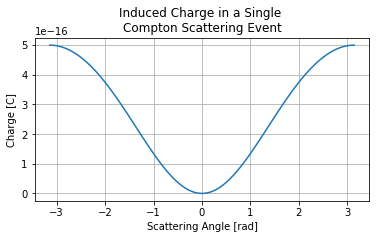

In [14]:
# Calculate Compton scattering for different angles
lambda_i = h_eV * c / E_i
Q_vec = []
for theta in theta_vec:
    lambda_f, num_ehp = scatter_compton(lambda_i, theta, E_ion)
    Q_vec.append(num_ehp*q)

# Plotting
fig, ax = plt.subplots(figsize=figsize)

ax.plot(theta_vec, Q_vec)
ax.set_ylabel('Charge [C]')
ax.set_xlabel('Scattering Angle [rad]')
ax.set_title('Induced Charge in a Single \nCompton Scattering Event')
ax.grid(True)

<h3>X-Ray</h3>

In [31]:
lambda_min = 1e-11
lambda_max = 1e-8

In [32]:
E_max = get_E(lambda_min)
E_min = get_E(lambda_max)

print(E_min, E_max)

124.08 124080.00000000001


<h3>Gamma</h3>

In [33]:
lambda_gamma = 1e-12
E_gamma = get_E(lambda_gamma)
E_gamma

1240800.0

<h1>One-Shot Results Statistics</h1>

<h2>Code Sweep</h2>

In [ ]:
file_names = ['../data/1p8/data_1nsPulse_randPeriod_R10kC1p_yesReset.csv', 
              '../data/1p8/data_1nsPulse_randPeriod_R20kC1p_yesReset.csv',
              '../data/1p8/data_1nsPulse_randPeriod_R30kC1p_yesReset.csv',
              '../data/1p8/data_1nsPulse_randPeriod_R40kC1p_yesReset.csv']
data_dicts = [parse_pulse(file_name) for file_name in file_names]

pulse_widths_specs = [dict(data_dict = data_dict,
                          sig_threshold = 0.9,
                          posedge = True) for data_dict in data_dicts]
pulse_widths_lists = [get_pulse_widths(**pulse_widths_spec) for pulse_widths_spec in pulse_widths_specs]

In [ ]:
# Plotting
figsize = (20, 10)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(pulse_widths_lists[0], 'red', label='3')
ax.plot(pulse_widths_lists[1], 'green', label='2')
ax.plot(pulse_widths_lists[2], 'blue', label='1')
ax.plot(pulse_widths_lists[3], 'yellow', label='0')

ax.set_xlabel('Pulse Number')
ax.set_ylabel('Output Pulse Width (s)')
ax.legend()
# ax.set_title(f'Mean = {np.average(pulse_width_list)*1e9} ns\nStdDev = {np.std(pulse_width_list)*1e9} ns')
ax.grid(True)

In [ ]:
# Histogram
figsize = (20, 5)
num_bins = 100

fig, ax = plt.subplots(figsize=figsize)
# ax.hist(pulse_width_list, bins=100)
ax.hist(pulse_widths_lists, bins=num_bins, label=['3', '2', '1', '0'])
# ax.hist(pulse_widths_lists[0], color='red', bins=num_bins, alpha=1, label='3')
# ax.hist(pulse_widths_lists[1], color='green', bins=num_bins, alpha=1, label='2')
# ax.hist(pulse_widths_lists[2], color='blue', bins=num_bins, alpha=1, label='1')
# ax.hist(pulse_widths_lists[3], color='black', bins=num_bins, alpha=1, label='0')
ax.set_xlabel('Pulse Width (s)')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True)
ax.set_title('One-Shot Output Pulse Width Distribution\nPulse Width = 1ns, Pulse Spacing = [10, 1000]ns, Randomly Sampled')
# ax.set_title('Pulse Width = 1ns\nPulse Spacing = [1, 100]ns, Randomly Sampled')

<h2>Monte Carlo</h2>

In [ ]:
file_names = ['../data/1p8/simData_0.csv', 
              '../data/1p8/simData_1.csv',
              '../data/1p8/simData_2.csv',
              '../data/1p8/simData_3.csv']
pulse_widths_lists = [[]] * 4

for code, fname in enumerate(file_names):    
    with open(fname) as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            row_flt = [float(x) for x in row]
            pulse_widths_lists[code] = pulse_widths_lists[code] + row_flt

In [ ]:
# Histogram
figsize = (20, 5)
num_bins = 10000

fig, ax = plt.subplots(figsize=figsize)
# ax.hist(pulse_width_list, bins=100)
ax.hist(pulse_widths_lists, bins=num_bins, label=['0', '1', '2', '3'])
# ax.hist(pulse_widths_lists[0], color='red', bins=num_bins, alpha=1, label='3')
# ax.hist(pulse_widths_lists[1], color='green', bins=num_bins, alpha=1, label='2')
# ax.hist(pulse_widths_lists[2], color='blue', bins=num_bins, alpha=1, label='1')
# ax.hist(pulse_widths_lists[3], color='black', bins=num_bins, alpha=1, label='0')
ax.set_xlabel('Pulse Width (s)')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True)
ax.set_title('One-Shot Output Pulse Width Distribution\nPulse Width = 1ns, Pulse Spacing = [10, 1000]ns, Randomly Sampled')
# ax.set_title('Pulse Width = 1ns\nPulse Spacing = [1, 100]ns, Randomly Sampled')

<h1>Folded Cascode</h1>
<h2>Checking Bode Plot of Folded Cascode vs. Sim</h2>

In [ ]:
num = np.array([-3.53895594e-004, -4.70738415e+007,  1.50356235e+019,
        2.47926605e+030,  1.59517475e+041,  5.75769776e+051,
        1.30387570e+062,  1.93756258e+072,  1.91312015e+082,
        1.24175010e+092,  5.11668364e+101,  1.24882971e+111,
        1.58562663e+120,  8.12989223e+128,  5.24596567e+136])
den = np.array([1.00000000e+000, 1.48311234e+011, 9.64486755e+021, 3.62458359e+032,
       8.73205029e+042, 1.41372736e+053, 1.56752525e+063, 1.18986463e+073,
       6.07158733e+082, 2.00068022e+092, 3.95710939e+101, 4.14370181e+110,
       1.90680507e+119, 2.22072378e+127, 7.55724493e+134])

s1 = signal.lti(num, den)
w, mag, phase = s1.bode()

In [ ]:
plt.figure()
plt.semilogx(w, mag, 'r')
plt.semilogx(w, phase, 'b')
plt.grid(True)

In [ ]:
print(mag[69])
print(phase[69])

<h1>Delay</h1>
<h2>Sallen Key Calculations</h2>

In [ ]:
tdelay = 2e-9
C1 = 50e-15
C2 = 30e-15

#############

omega_0 = 1/tdelay
k1 = 1/(3 * omega_0**2 * C1 * C2)
k2 = 3*omega_0 * C1 * k1

# x(k2 - x) = k1 -> x^2 - k2x + k1 = 0
sqrt_term = k2**2 - 4*k1
print(sqrt_term)

R1_plus = (k2 + np.sqrt(sqrt_term))/2
R1_minus = (k2 - np.sqrt(sqrt_term))/2

R2_plus = k2 - R1_plus
R2_minus = k2 - R1_minus

In [ ]:
print(R1_plus, R1_minus)
print(R2_plus, R2_minus)

In [ ]:
R1_plus+R2_plus

In [ ]:
k2

<h1>Peak Detector + Attenuator</h1>
<h2>Error Plot</h2>

In [ ]:
file_name = '../data/peakDetector_attenuator_error.csv'
data = pd.read_csv(file_name)
code_vec = list(data['code'])
data_n85 = list(data['-85'])
data_27 = list(data['27'])
data_125 = list(data['125'])

figsize = (20, 10)
fig, ax = plt.subplots(figsize=figsize)

ax.semilogy(code_vec, data_n85, 'r-o', label='-85')
ax.semilogy(code_vec, data_27, 'g-*', label='27')
ax.semilogy(code_vec, data_125, 'b--', label='125')
ax.legend()
ax.grid(True)
ax.set_title('Peak Detector + Attenuator Output Error\nVstep=229.86mV')
ax.set_xlabel('Digital Code')
ax.set_ylabel('Error (mV)')